## Predicting Travel Insurance Claims

### Abstract

This project aims to predict whether a particular insurance claim should be given out or not. Using historical data containing details about claims that were and weren't given, the aim is to predict claims for unseen data (claims filed in future).

This project takes the reader through the data cleansing, feature engineering, and modelling aspects of the solution.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import time
import warnings

from matplotlib import pyplot as plt

from scipy import stats

from my_utils import *

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
data = pd.concat([train, test])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63214 entries, 0 to 12660
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    63214 non-null  int64  
 1   Agency                63214 non-null  object 
 2   Agency Type           63214 non-null  object 
 3   Distribution Channel  63214 non-null  object 
 4   Product Name          63214 non-null  object 
 5   Claim                 50553 non-null  float64
 6   Duration              63214 non-null  int64  
 7   Destination           63214 non-null  object 
 8   Net Sales             63214 non-null  float64
 9   Commision (in value)  63214 non-null  float64
 10  Gender                18205 non-null  object 
 11  Age                   63214 non-null  int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 6.3+ MB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,63214.0,31667.360094,18280.432565,0.0,15837.25,31673.5,47498.75,63325.0
Claim,50553.0,0.014658,0.120180,0.0,0.00,0.0,0.00,1.0
Duration,63214.0,49.325498,101.857143,-2.0,9.00,22.0,53.00,4881.0
Net Sales,63214.0,40.670256,48.857439,-389.0,18.00,26.5,48.00,810.0
Commision (in value),63214.0,9.813792,19.809089,0.0,0.00,0.0,11.55,283.5
Age,63214.0,39.972664,14.019164,0.0,35.00,36.0,43.00,118.0


In [5]:
check_null(data)

Total Columns: 63214


,Number_Missing,% Missing,Missing?
Gender,45009,71.201000,True
Claim,12661,20.028791,True


In [6]:
data.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,3433,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0.0,7,MALAYSIA,0.0,17.82,NaN,31
1,4339,EPX,Travel Agency,Online,Cancellation Plan,0.0,85,SINGAPORE,69.0,0.00,NaN,36
2,34590,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0.0,11,MALAYSIA,19.8,11.88,NaN,75
3,55816,EPX,Travel Agency,Online,2 way Comprehensive Plan,0.0,16,INDONESIA,20.0,0.00,NaN,32
4,13816,EPX,Travel Agency,Online,Cancellation Plan,0.0,10,"KOREA, REPUBLIC OF",15.0,0.00,NaN,29


## 1 Data Cleaning and Feature Engineering

In [7]:
data['ID'].nunique()

63214

In [8]:
data.drop(columns=['Gender'], axis=1, inplace=True)

* Due to a very high number of missing values, Gender is dropped.

In [9]:
data.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age
0,3433,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0.0,7,MALAYSIA,0.0,17.82,31
1,4339,EPX,Travel Agency,Online,Cancellation Plan,0.0,85,SINGAPORE,69.0,0.00,36
2,34590,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0.0,11,MALAYSIA,19.8,11.88,75
3,55816,EPX,Travel Agency,Online,2 way Comprehensive Plan,0.0,16,INDONESIA,20.0,0.00,32
4,13816,EPX,Travel Agency,Online,Cancellation Plan,0.0,10,"KOREA, REPUBLIC OF",15.0,0.00,29


In [10]:
data['Agency'].nunique()

16

In [11]:
data['Product Name'].nunique()

25

# Agency and Product Name

* Let's have a look at the frequency of data wrt Agency and Product Name.

<Figure size 864x432 with 0 Axes>

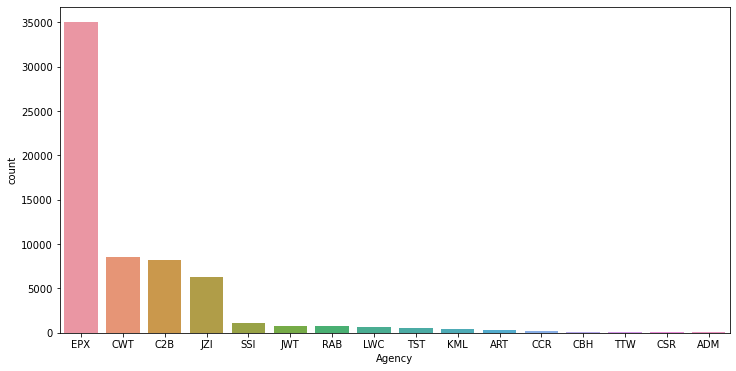

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Agency', data=data,
             order=data['Agency'].value_counts().index)

* EPX seems to be the most popular agency with well over 55% of the claims filed through it.
* Let's have a look at the number of claims approved across the products offered by the agencies.

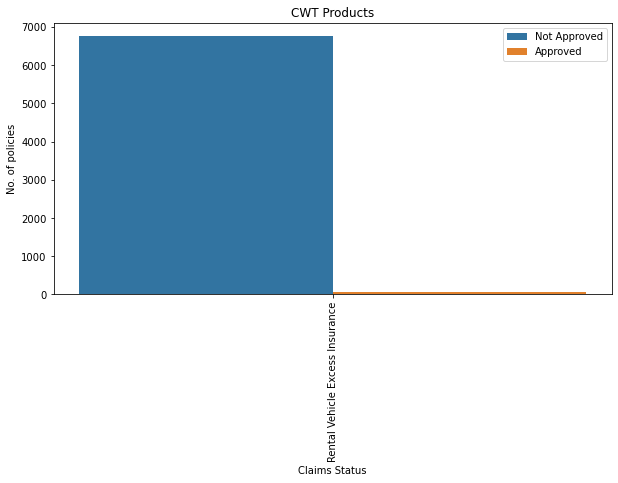

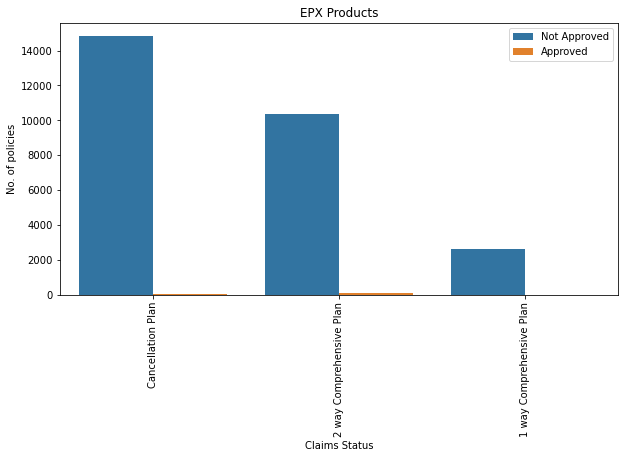

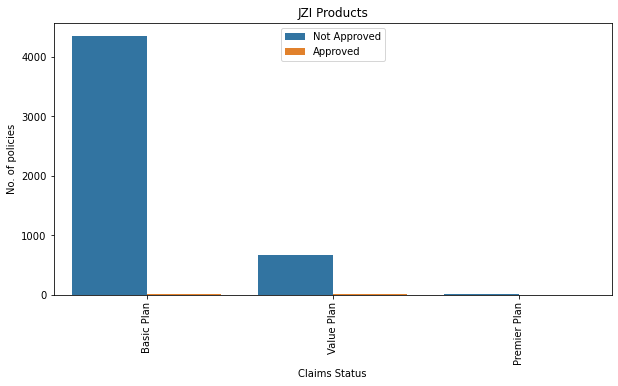

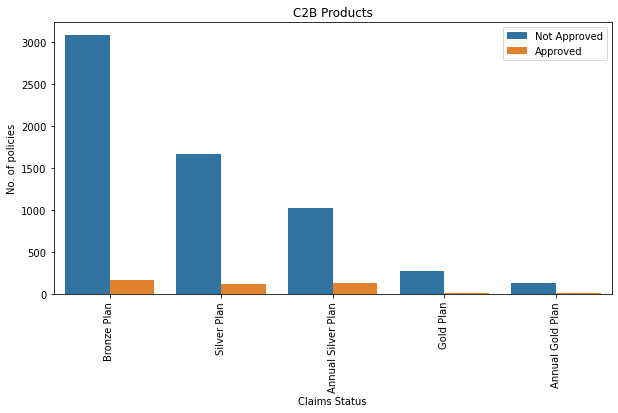

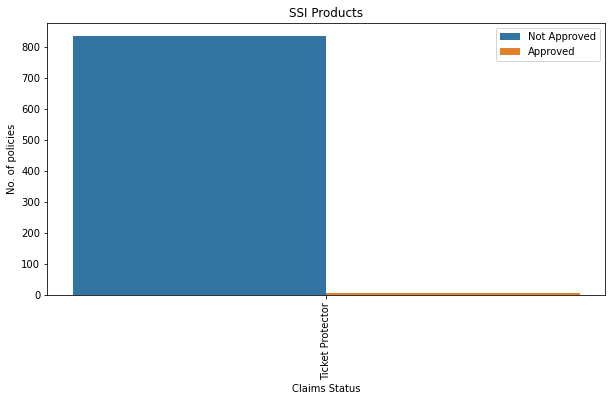

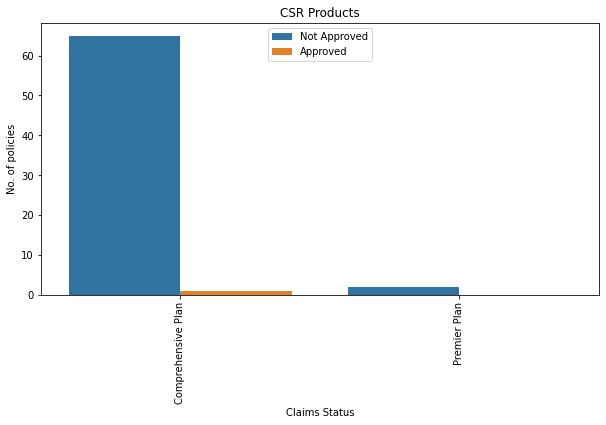

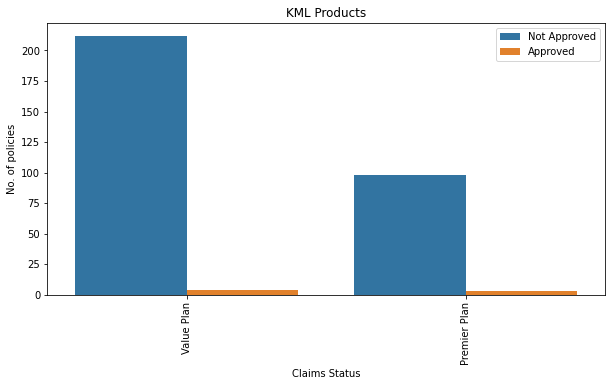

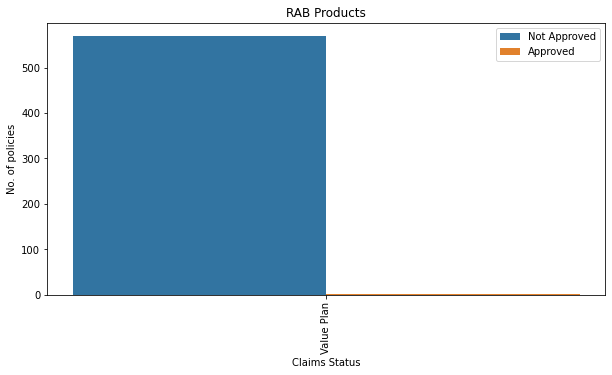

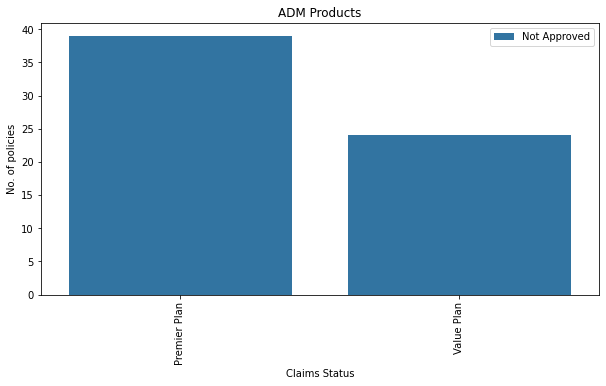

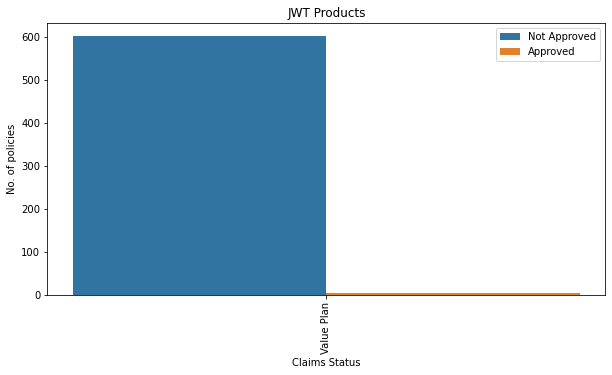

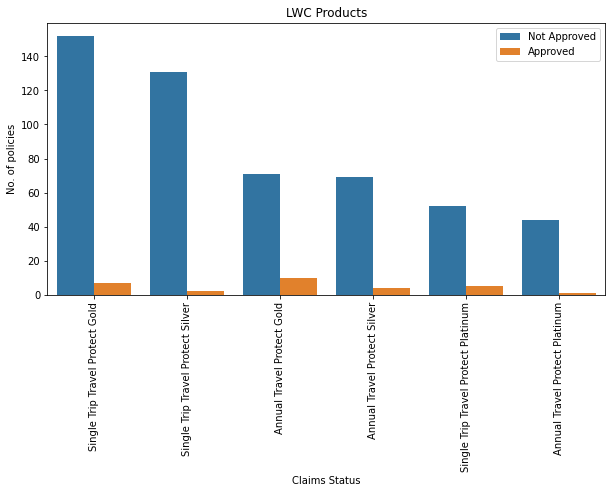

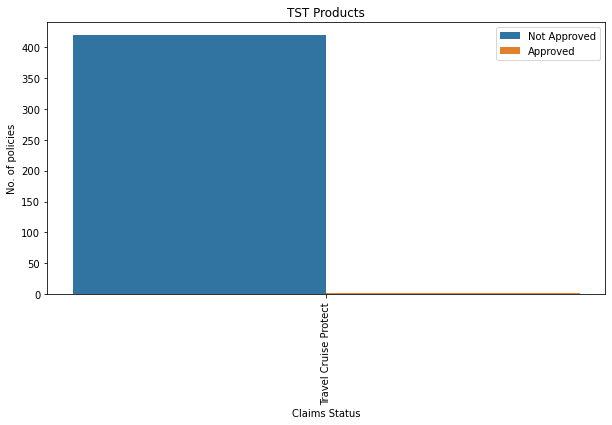

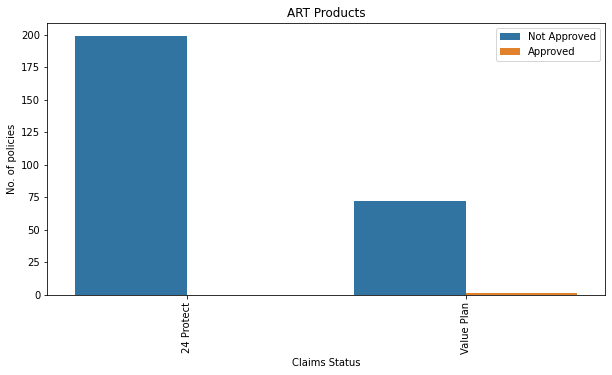

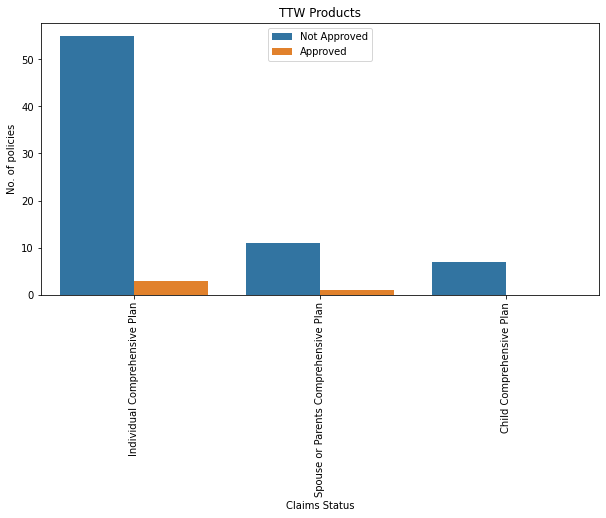

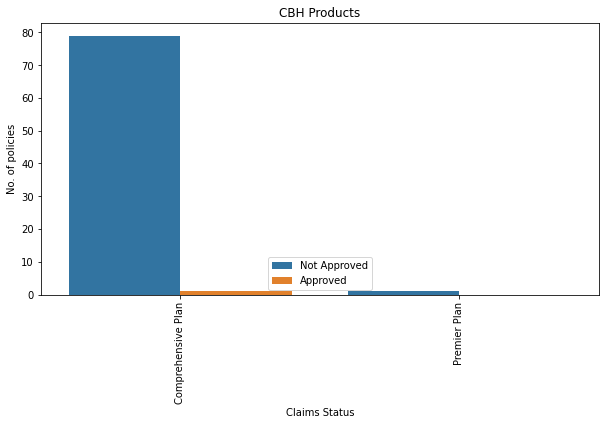

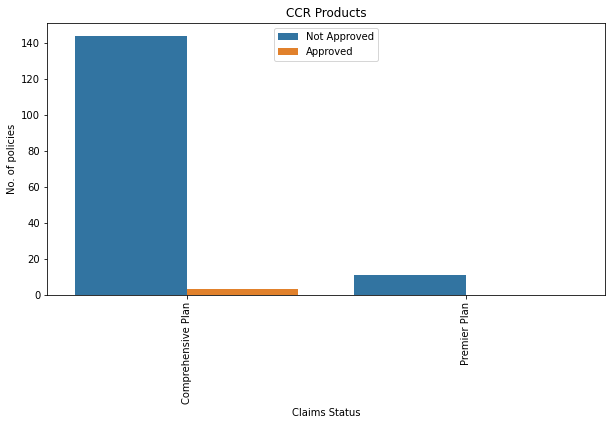

In [13]:
for agency in data['Agency'].unique():
    mask = data['Agency'] == agency
    _ = plt.figure(figsize=(10, 5))
    figure = sns.countplot(x='Product Name',
                          data=data[mask],
                          order=data[mask]['Product Name'].value_counts().index,
                          hue='Claim',)
    _ = figure.set_title(f'{agency} Products')
    _ = figure.set(ylabel='No. of policies', xlabel='Claims Status')
    _ = figure.legend(['Not Approved', 'Approved'])
    _ = figure.set_xticklabels(figure.get_xticklabels(), rotation=90)

* Claim approval is highly imbalanced where is some cases, claims are not given out entirely.
* Checking how the probablity of a claim being given varies wrt a company product.

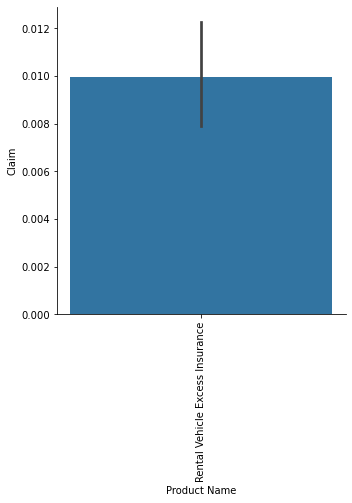

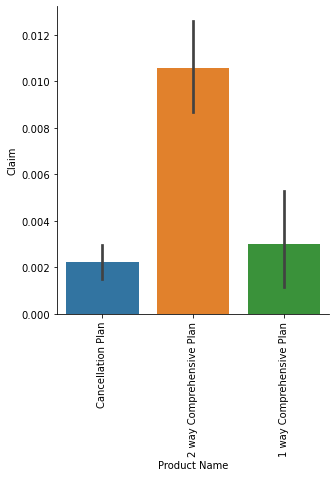

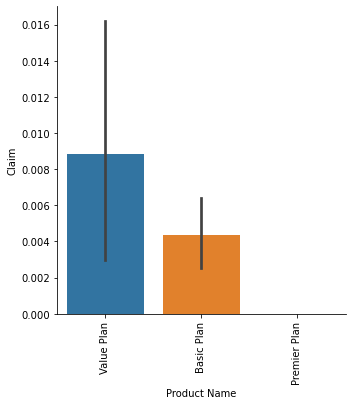

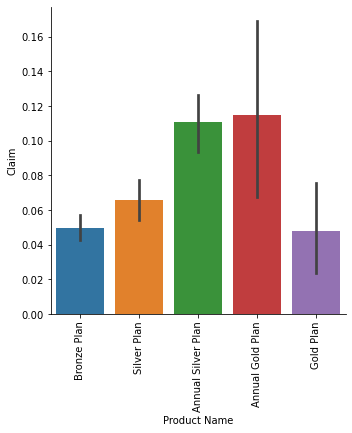

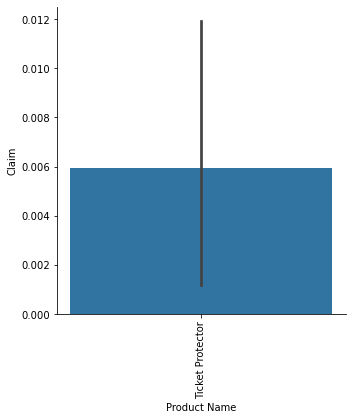

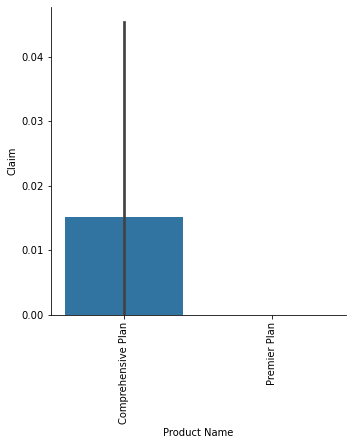

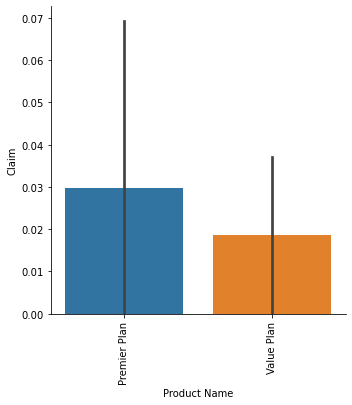

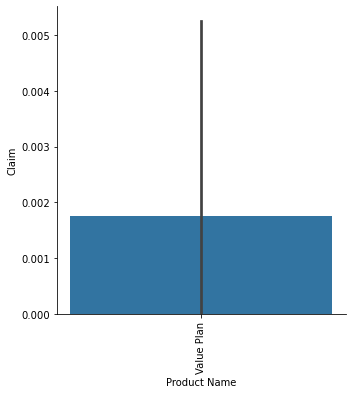

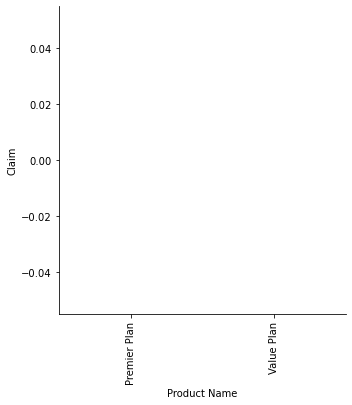

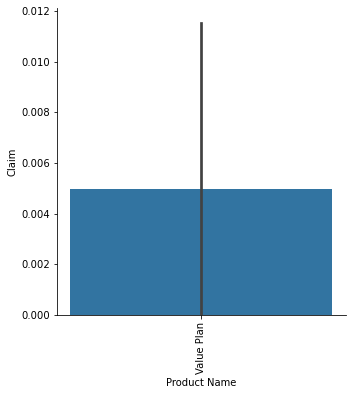

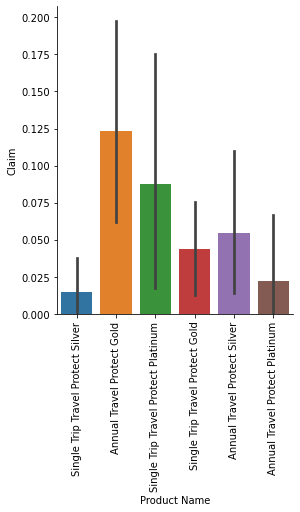

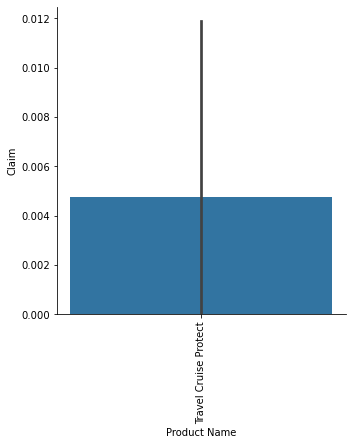

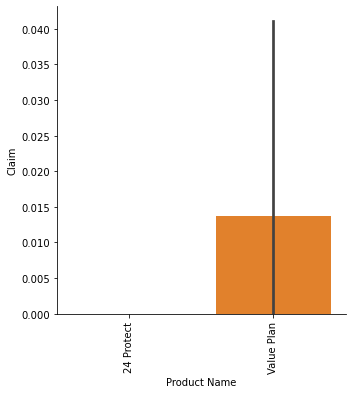

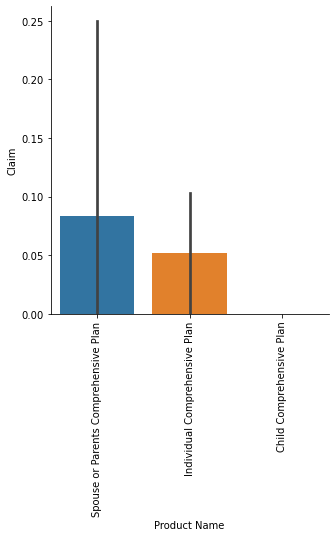

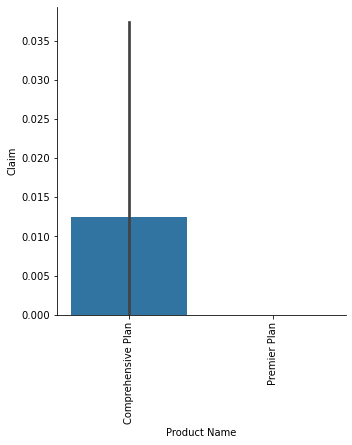

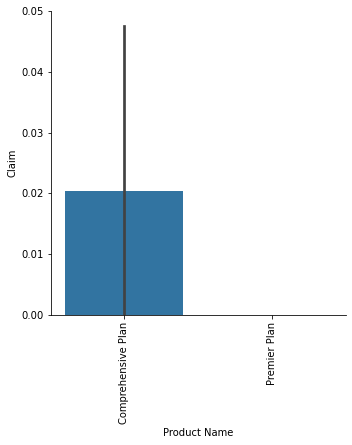

In [14]:
# Probablity of a claim being approved for products of a company
for agency in data['Agency'].unique():
    figure = sns.factorplot(x='Product Name', y='Claim', data=data[data['Agency'] == agency], kind='bar')
    _ = plt.xticks(rotation=90)

* While the general trend is that the more expensive product has a higher claim approval, there are instances where the most expensive plan does not imply the highest claim probablity.

In [15]:
data = pd.get_dummies(data, columns=['Agency', 'Product Name'])

# Agency Type

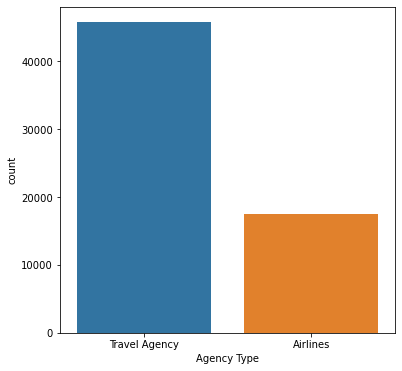

In [16]:
_ = plt.figure(figsize=(6, 6))
figure = sns.countplot(x='Agency Type', data=data)

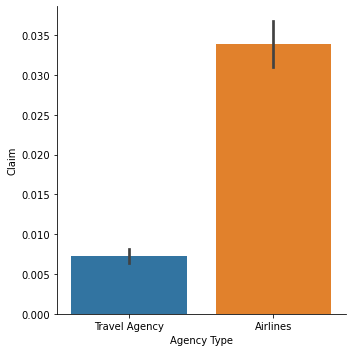

In [17]:
figure = sns.factorplot(x='Agency Type', y='Claim', data=data, kind='bar')

* While airlines agency type have a lower total number of instanes, its probablity of a claim being approved is about 4 times higher than that of a travel agency.

In [18]:
data = pd.get_dummies(data, columns=['Agency Type'])

# Distribution Channel

<Figure size 864x432 with 0 Axes>

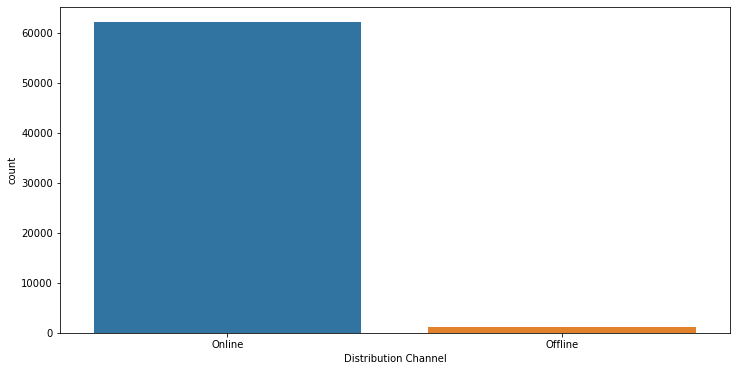

In [19]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Distribution Channel', data=data,
             order=data['Distribution Channel'].value_counts().index)

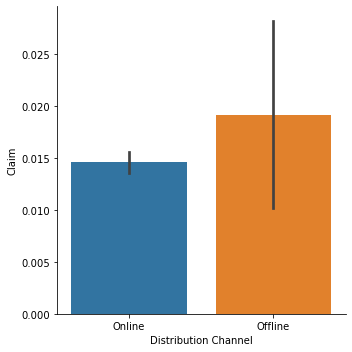

In [20]:
figure = sns.factorplot(x='Distribution Channel', y='Claim', data=data, kind='bar')

* The variation in probablity of claims given out is significantly lesser in case of online distribution channels.
* This may mean that the percentage of claims given out are regulated.

In [21]:
data = pd.get_dummies(data, columns=['Distribution Channel'])

# Duration

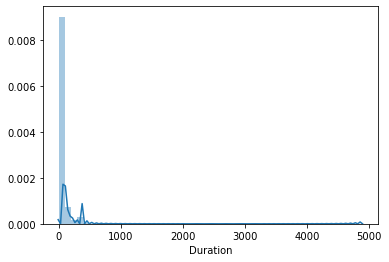

In [22]:
sns.distplot(data['Duration'])

* Duration is highly skewed. Log transform is applied.

In [23]:
data['Duration'] = data['Duration'].apply(log_transform)

# Destination

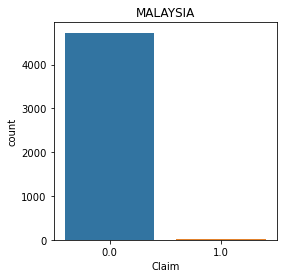

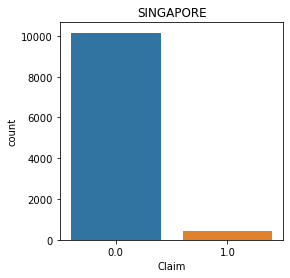

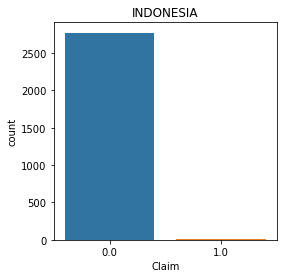

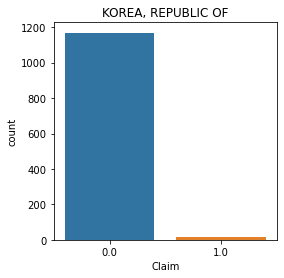

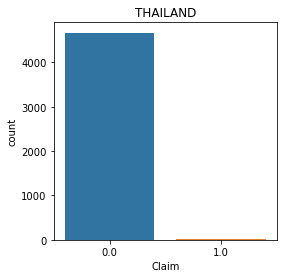

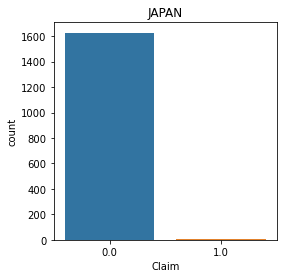

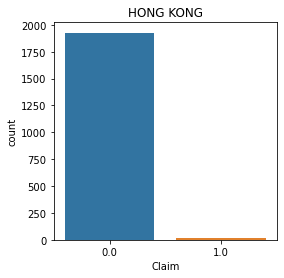

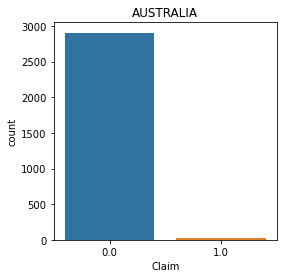

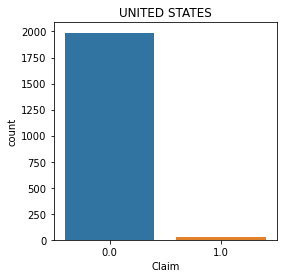

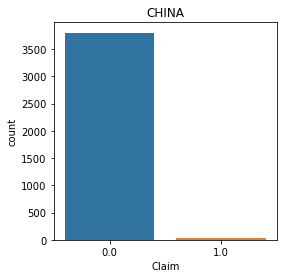

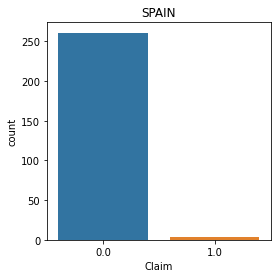

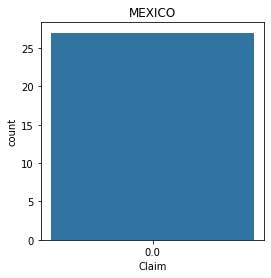

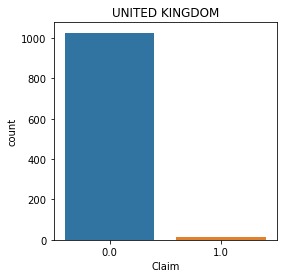

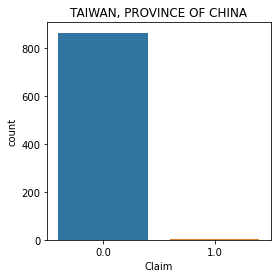

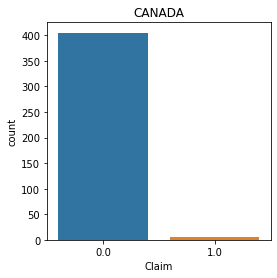

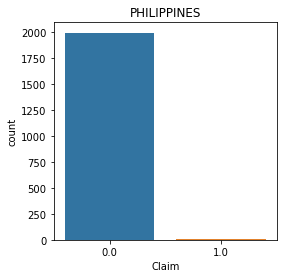

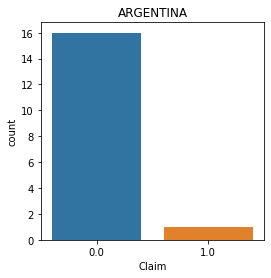

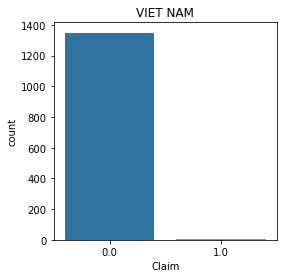

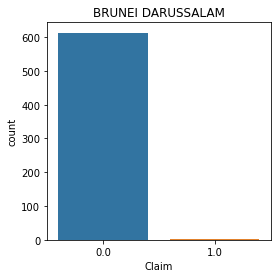

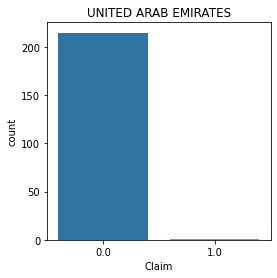

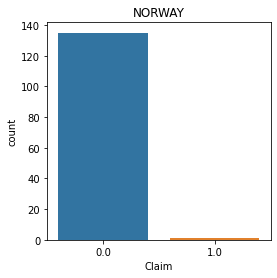

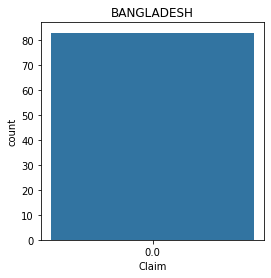

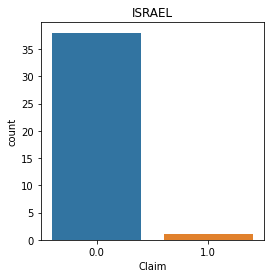

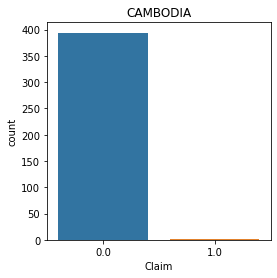

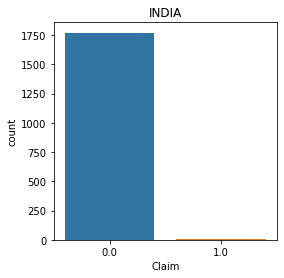

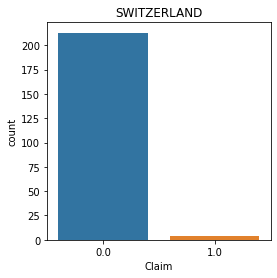

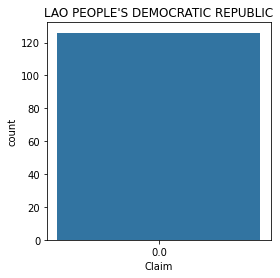

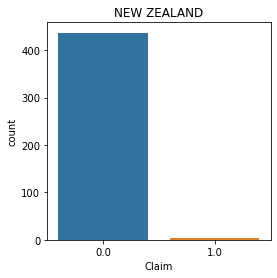

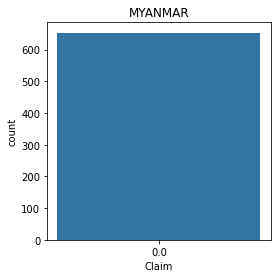

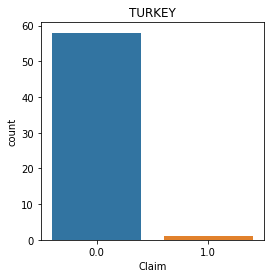

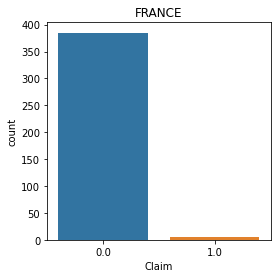

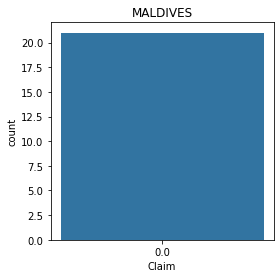

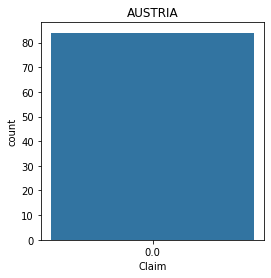

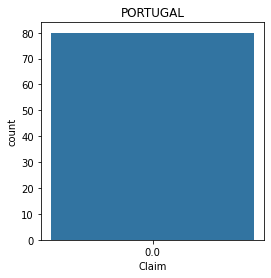

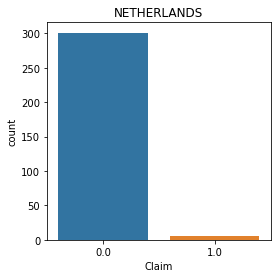

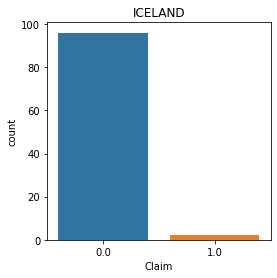

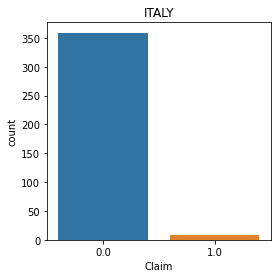

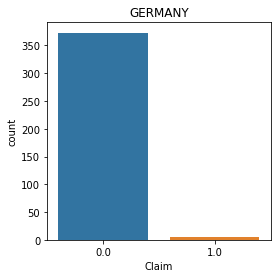

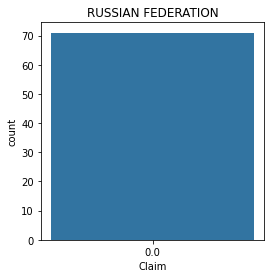

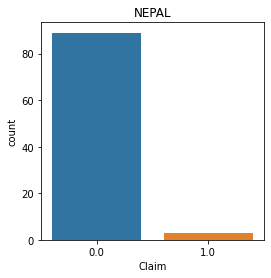

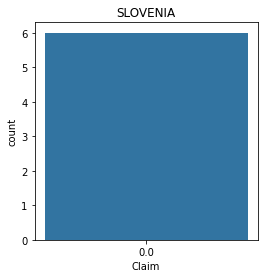

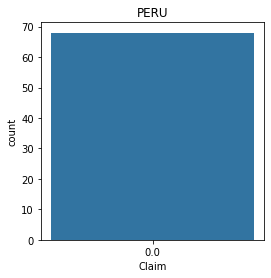

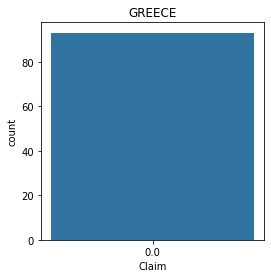

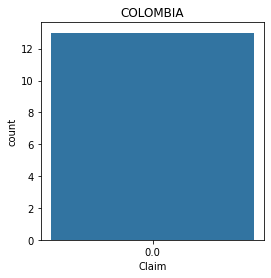

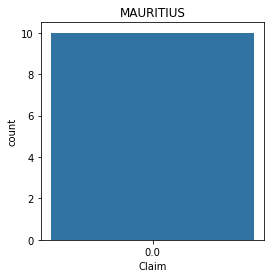

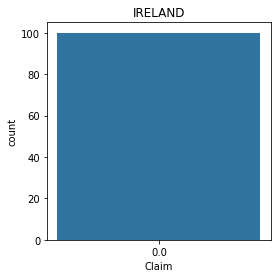

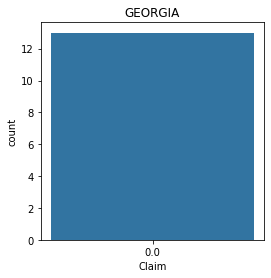

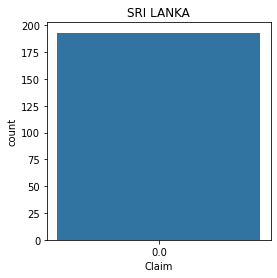

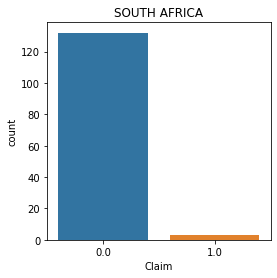

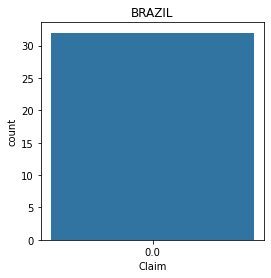

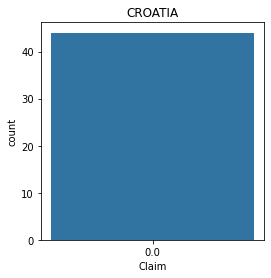

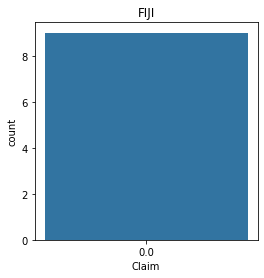

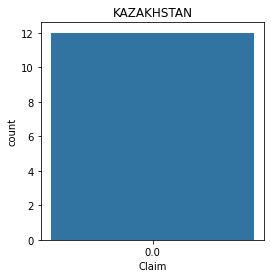

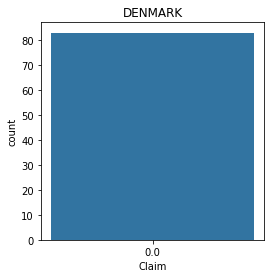

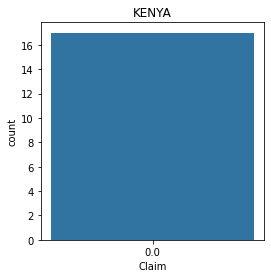

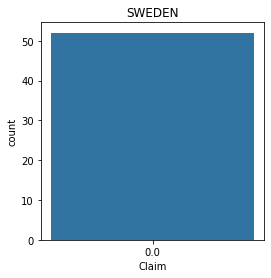

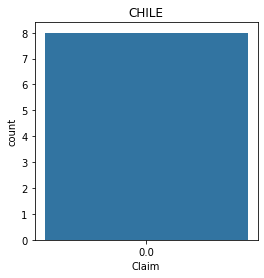

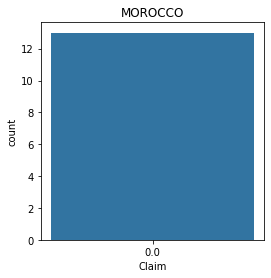

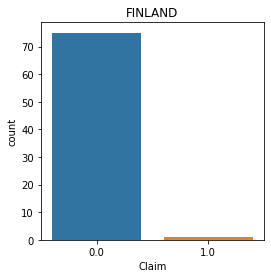

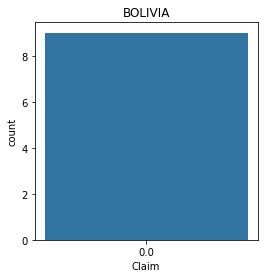

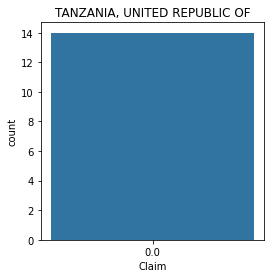

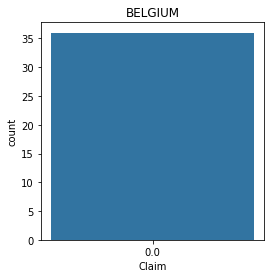

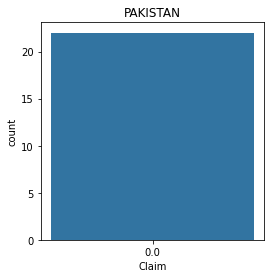

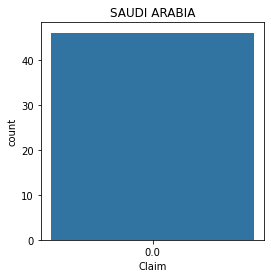

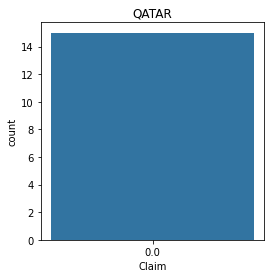

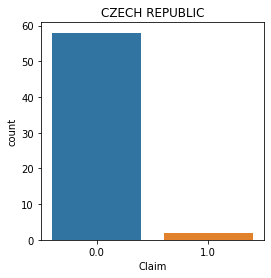

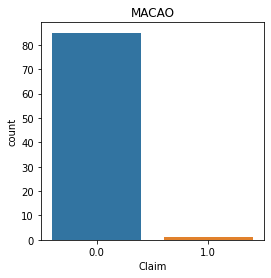

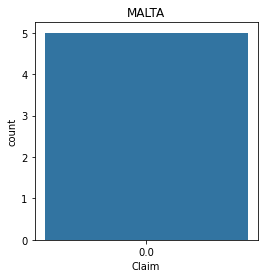

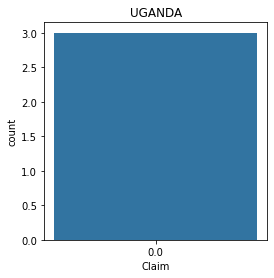

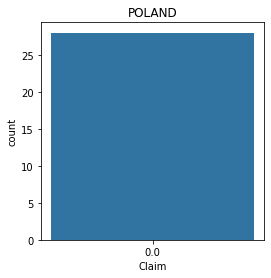

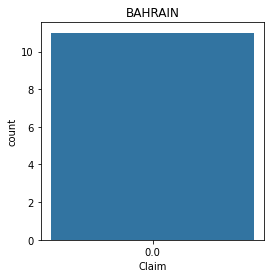

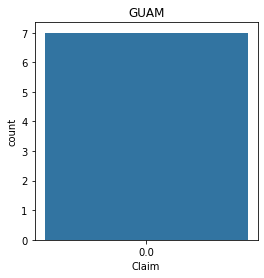

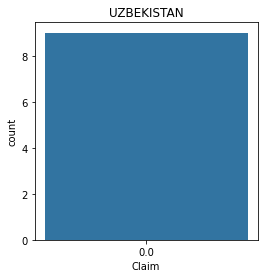

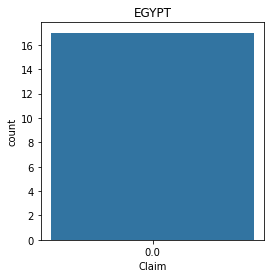

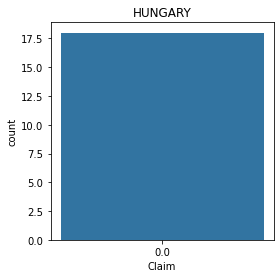

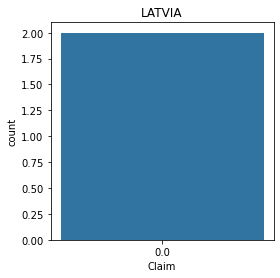

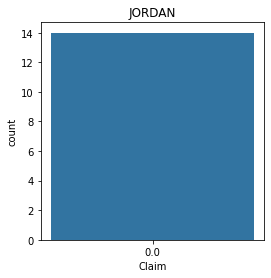

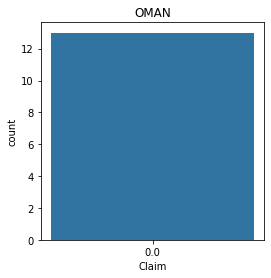

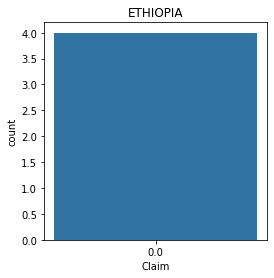

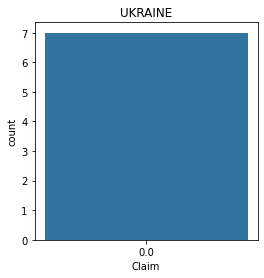

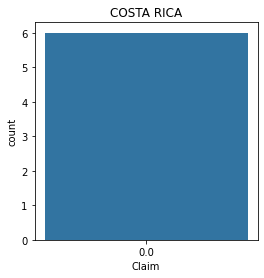

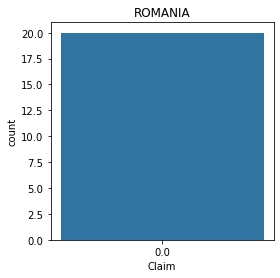

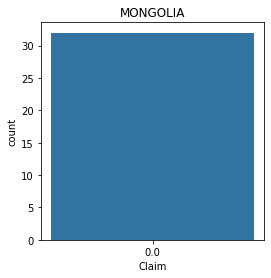

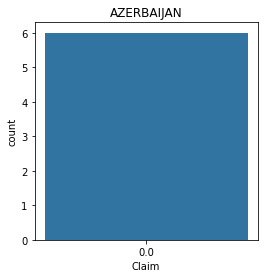

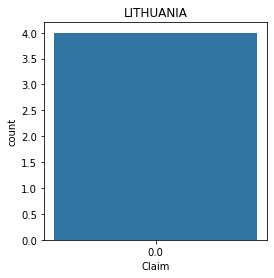

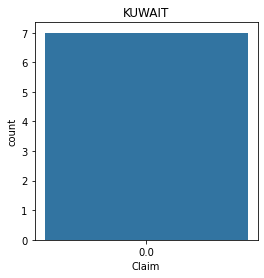

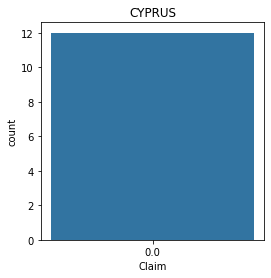

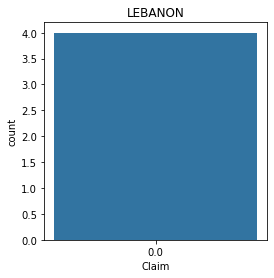

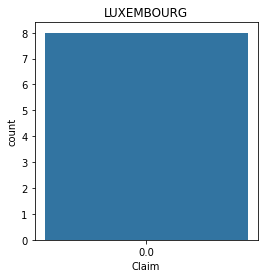

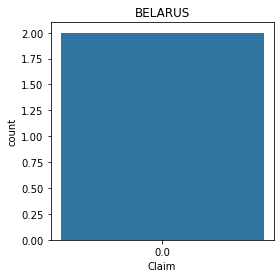

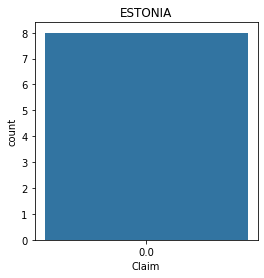

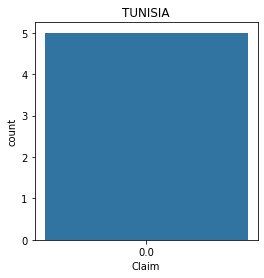

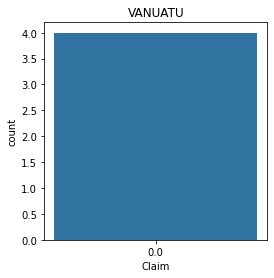

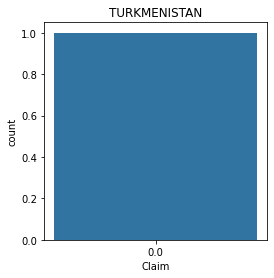

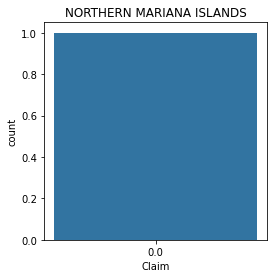

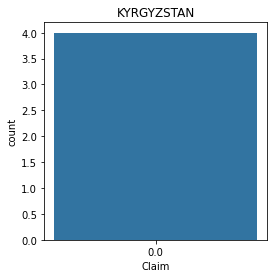

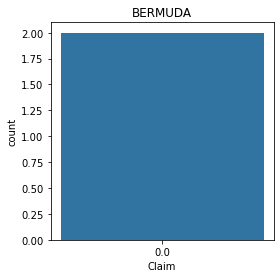

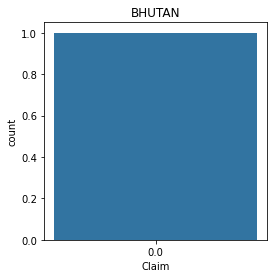

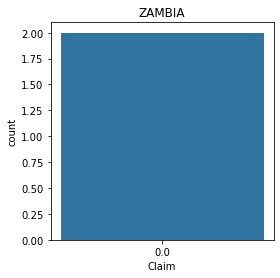

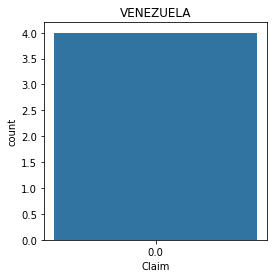

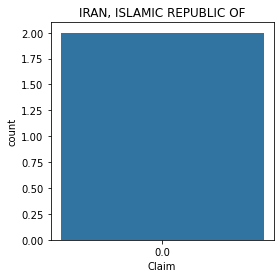

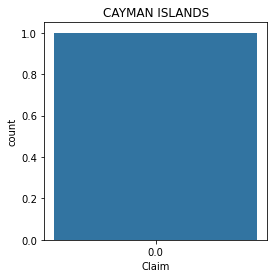

In [24]:
for destination in data['Destination'].unique():
    mask = data['Destination'] == destination
    _ = plt.figure(figsize=(4, 4))
    figure = sns.countplot(x='Claim', data=data[mask],
                           order=data[mask]['Claim'].value_counts().index)
    _ = plt.title(destination)

In [25]:
data = pd.get_dummies(data, columns=['Destination'])

# Net Sales

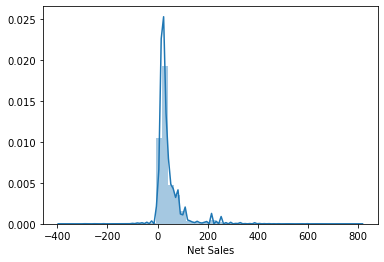

In [26]:
sns.distplot(data['Net Sales'])

* Net Sales is skewed. Square root transform is applied.

In [27]:
data['Net Sales'] = data['Net Sales'].apply(sqrt_transform)

# Commission

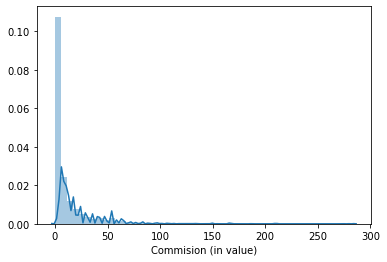

In [28]:
sns.distplot(data['Commision (in value)'])

* Commission is highly skewed. Boxcox transform is applied.

In [29]:
data['Commision (in value)'] = boxcox_transform(data['Commision (in value)'])

# Age

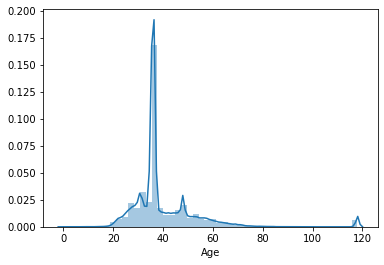

In [30]:
sns.distplot(data['Age'])

* Age contains outliers. Dropping them and applying boxbox transform.

In [31]:
train.drop(train[ train['Age'] > 100 ].index, axis=0, inplace=True)

In [32]:
data['Age'] = boxcox_transform(data['Age'])

## Finalizing and saving data

In [33]:
data.head()

,ID,Claim,Duration,Net Sales,Commision (in value),Age,Agency_ADM,Agency_ART,Agency_C2B,Agency_CBH,...,Destination_UGANDA,Destination_UKRAINE,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA
0,3433,0.0,1.945910,0.000000,2.761046,4.289159,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4339,0.0,4.442651,8.306624,-28.597546,4.521050,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34590,0.0,2.397895,4.449719,2.386450,5.724322,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55816,0.0,2.772589,4.472136,-28.597546,4.338032,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13816,0.0,2.302585,3.872983,-28.597546,4.187125,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
train_p = data[ data['Claim'].notnull() ].copy()
test_p = data[ data['Claim'].isnull() ].copy()

In [35]:
train_p.to_csv("processed_data/train_processed.csv")
test_p.to_csv("processed_data/test_processed.csv")

----